# "Who can help me?" - Exploring the use of similarity scores to identify help requests in FCC chat

The idea of this project was to see if we could identify help requests using a similarity scoring again a non-annotated corpus. 


One of the problem was to find an appropriate corpus for comparison. The used corpus was the Ubuntu BAQ (boot-answerable questions) corpus by Utus and Aha (http://daviduthus.org/UCC/). The selection of this corpus was because it refers to technical requests for help in a similar way as they occur in the FCC chat. However by using this corpus set we confronted two important methodological challenges:
* The questions made to Ubuntu are very different in content as they ask for help about very specific Ubuntu technologies
* The corpus consists only of positive control utterances and lacks of negative control questions: those that would help to identify if the target sentence was NOT a request for help

Because of the second reason, the BAQ corpus can not be used for eager supervised learning classification. In this project, we explored the use of a lazy method, extending features by including an additional comparison to a modification of the same BAQ corpus.

Two type of comparisons were made using the same corpus:
* the *baq* comparison which considered a simple cosine similarity scoring, focused on sentence's *content*
* the *mbaq* comparison which consisted in modifying the BAQ corpus to determine the order of the words in a sentence, and in this way approximate our analysis also to the *structure*

Here the (quick and dirty) results of the analysis of the chatting of one of the campers.

Part of the code resides [in this Gist](https://gist.github.com/evaristoc/3edec1ac7cfc602d4e93).

The main functionalities are:
* Data cleaning, focusing on cleaning fragments like code, punctuations, stopwords, etc
* Tokenization (nltk word_tokenize module; nltk tutorial)
* Sentence Segmentation (using the nltk treebank classifier)
* Word order analysis (attached a number to the word according to its position in a sentence after considering punctuation marks or joining words (but, and, etc))
* Cosine Similarity scoring

To prepare the data for this project, the following was done:
* All the messages by the camper selected camper (AdventureBear, with authorization) were extracted from the whole pool of messages during Jan-Jul 2015.
* The code includes tagging of links and code sections, and also a positional analysis (not used for this project)
* The pre-processing also included tokenization, sentence segmentation, and discharge of punctuation marks and stopwords 
* Then a SIM ANALYSIS (for similarity analysis) was carried out; the Sim Analysis was done only on a small fraction of the available utterances (a sample of ~350). the procedure was a one-by-one comparison of each utterance to the utterances in the baq and mbaq corpora. The scores were averaged separately giving 2 similarity scores, 1 per corpus.

In order to determine the existence of a trend, the bi-dimensional spaces of both scores was divided in regions originated by the intersection of the regressions that explained, on one hand, the baq scores as function of mbaq scores, and on the other, the mbaq scores as function of baq scores (see figure below). With this we affirmed that:
* There were utterances which were not similar to BAQ corpus in any way (Region 1)
* There were utterances which were likely similar to the BAQ corpus in content as well as structure (Region 3)
* There were utterances which were likely similar to the BAQ corpus in structure but not content (Region 2)
* There were utterances which were likely similar to the BAQ corpus in content but not structure  (Region 4)

After that, the sample of utterances were annotated according to a personal judgement as help requests (1) or not (0). There were a few of phrases for which the act-of-speech was not clear: they received a different classification (2).

The table below shows the results of the comparison.  



|regions|  0  |  1  |   2 |  Tot|
|-------|-----|-----|-----|-----|
|      1|   88|    2|    2|   99|
|      2|   93|   20|    2|  115|
|      3|   24|   18|    6|   48|
|      4|   79|    7|    7|   93|
|-------|     |     |     |     |
| Total |  284|   47|   17|  348|

Some interesting results came from the comparison:
* The methodology detected clearly when no much similarity was found. This is understable.
* Regions 2 and 4 behaved in a similar way and they added substantial noise to part-of-speech detection. This was somehow expected.
* Region 3, which was thought as the region where most of the targeted utterances would be captured, did its job: from all utterances in this region, about 45% where labelled as help requests. The region detected about 43% of the total utterances labelled as help requests and just a 14% of total utterances.

A file was prepared and analysed. A graph can be seen below:

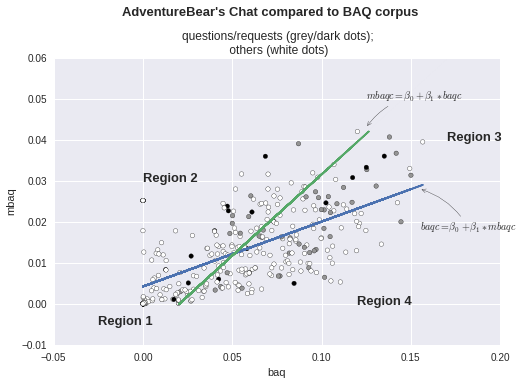

In [1]:
%matplotlib inline

import os, sys
import re, math,random
import csv
from collections import Counter
from datetime import datetime, date, timedelta
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
import pickle
import pandas
import nltk
from nltk.corpus import treebank_raw as treebank
import statsmodels.api as sm
import statsmodels.formula.api as smf

directory = "/data_analysis/"

with open(directory+'tests_chatan/revised_pandas_sens_an_3.csv', 'r') as f:
    header = f.readline().split('\t')
    stop = f.readline()
    l = stop.split('\t')
    d = []
    while stop:
        d.append(l)
        stop = f.readline()
        l = stop.split('\t')

pndfile = pandas.DataFrame(d, columns=header)
pndfile[['baqc','mbaqc','posc']] = pndfile[['baqc','mbaqc','posc']].astype('float')
pndfile[['regions','annotation']] = pndfile[['regions','annotation']].astype('int')

result1 = smf.ols('mbaqc ~ baqc', data=pndfile).fit()
result2 = smf.ols('baqc ~ mbaqc', data=pndfile).fit()

fig = plt.figure()
fig.suptitle("AdventureBear's Chat compared to BAQ corpus", fontsize=13, fontweight='bold')

ax = fig.add_subplot(111)
fig.subplots_adjust(top=0.85)
ax.set_title('questions/requests (grey/dark dots);\n others (white dots)')
ax.set_xlabel('baq')
ax.set_ylabel('mbaq')
ax.text(-.025, -.005, 'Region 1', fontsize=13, fontweight='bold')
ax.text(0.0, .03, 'Region 2', fontsize=13, fontweight='bold')
ax.text(0.17, .04, 'Region 3', fontsize=13, fontweight='bold')
ax.text(0.12, 0.0, 'Region 4', fontsize=13, fontweight='bold')
ax.annotate(r'$mbaqc = \beta_0 + \beta_1*baqc$', xy=(.125, .043), fontsize=10, xytext=(.125, .05), arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2"))
ax.annotate(r'$baqc = \beta_0 + \beta_1*mbaqc$', xy=(.155, .028), fontsize=10, xytext=(.155, .018), arrowprops=dict(arrowstyle="->",connectionstyle="arc3,rad=.2"))

plt.scatter(pndfile.baqc, pndfile.mbaqc, c=pndfile.annotation)
plt.plot(pndfile.baqc, result1.fittedvalues)
plt.plot(result2.fittedvalues, pndfile.mbaqc)
plt.show()


### Observations and Conclusions

As observations/conclusions we can say:
* It is important to mention that the data processing with this method is very slow and it could be hardly improved
* Although the region 3 was good in capturing help requests utterances its precision is not high, suggesting a 50-50 chance of correctly detecting a help request for the case under study. It should be higher to be a more useful method (IMO)
* It is expected that the method can be improved by adding labelled utterances to the corpus and transforming it into a eager classifier
* Although in the case of AdventureBear this made a relatively good job, it is still possible that there are strong variations between campers if the methodology is used for each: the use of the language could change between people, reducing/increasing the similarity to the BAQ corpus accordingly 